In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('/content/drive/MyDrive/LM/names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '-->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182467, 3]) torch.Size([182467])
torch.Size([22808, 3]) torch.Size([22808])
torch.Size([22871, 3]) torch.Size([22871])


In [6]:
# F.one_hot(X, num_classes=27).float() @ C
# btw this is just matrix multiplication of matrices 
# 3x27 and 27x2, then stacking the 3x2 vectors of N samples   
# so pytorch has no problem with the product of 3D and 2D
# tensors (gets around without broadcasting), but can't
# product 3D and 3D.

In [7]:
## different approaches to concatenation
# torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]], 1) not generalizable
# torch.cat(torch.unbind(emb, 1), 1) # unbind removes a dim. this returns a tuple
# of block_size tensors, each 32x2
# emb.view(-1, 6) more efficient way

In [139]:
C = torch.randn((27, 10)) # embedding matrix
W1 = torch.randn((30, 300))
b1 = torch.randn(300)
W2 = torch.randn((300, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

sum(param.nelement() for param in parameters)

17697

In [140]:
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre
# lri = []
# lossi = []
# stepi = []
for i in range(200000):
    # mini-batch
    # now the update is not in the actual gradient direction, but good enough;
    # in practice, it's better to take many approximately good steps
    # instead of few good steps
    ix = torch.randint(0, Xtr.shape[0], (64,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(X.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # logits -= logits.max() solves
    # exploding logits.exp()

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track
    # lri.append(lre[i])
    # stepi.append(i)
    # lossi.append(loss.item())

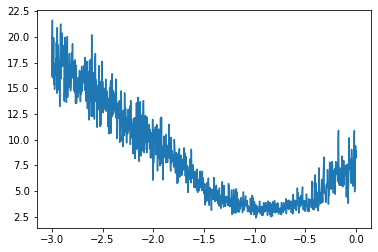

In [99]:
# plt.plot(lri, lossi)

In [141]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.0990991592407227


In [142]:
# development
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1711552143096924


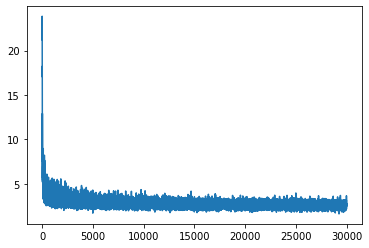

In [115]:
# plt.plot(stepi, lossi)
# lr=.1, bigger hidden layer
# mini-batch creates this noise

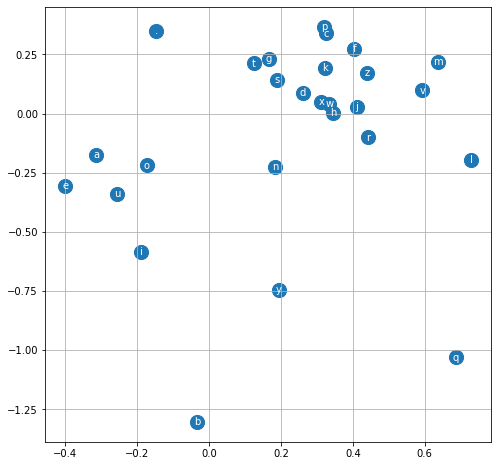

In [121]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


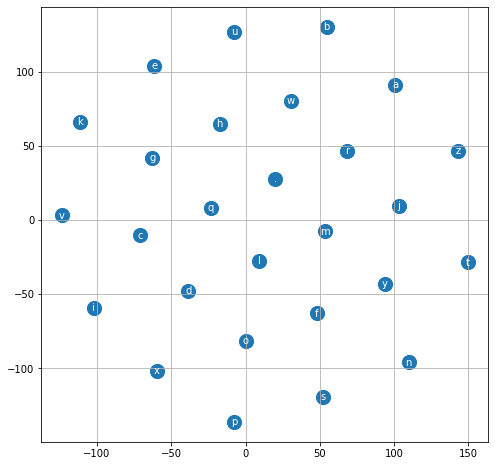

In [145]:
# visualize 10-dim. embeddings with t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(2)
tsne_result = tsne.fit_transform(C.detach().numpy())

plt.figure(figsize=(8,8))
plt.scatter(tsne_result[:,0], tsne_result[:,1], s=200)
for i in range(C.shape[0]):
  plt.text(tsne_result[i,0], tsne_result[i,1], itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [148]:
# sampling from the model
for _ in range(20):
  out = []
  context = [0] * 3
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

dayah.
beira.
mya.
tas.
gia.
zeyah.
theod.
embedenai.
mavand.
joaluse.
theem.
odencite.
crecerlin.
ila.
cora.
sosaialey.
firin.
androh.
has.
ber.
